In [1]:
%matplotlib inline

This is playing with pytorch framework for EHR modeling. In general, a patient's health record can be represented as a sequence of visits. Each visit has certain features, and can be represented as a list of medical codes.

For simplicity, we are starting with the data structure that a patient's health record is a list of list, following the line of work from Jimeng Sun's lab. We will use codes from Ed Choi to manipulate the data. 

The core model is an GRU.

# todos:
* dropout
* L1/L2 regularization
* validation and AUC

In [2]:
from __future__ import print_function, division
from io import open
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

In [7]:
# prepare data: load the input file containing list of list of list, and corresponding label file
# and output the merged list of pairs
import sys, random
import numpy as np
import cPickle as pickle

# set random seed
random.seed( 3 )

seqFile = 'data/cerner/hospital_data/h143.visits'
labelFile = 'data/cerner/hospital_data/h143.labels'
set_x = pickle.load(open(seqFile, 'rb'))
set_y = pickle.load(open(labelFile, 'rb'))

labeled_ehr_seq_list = [(set_y[i],set_x[i]) for i in range(len(set_x))] # merge the two lists

In [10]:
labeled_ehr_seq_list[1]

(0,
 [[5814, 714, 6636, 109, 84, 85],
  [714, 109, 84, 85],
  [150, 714, 673, 109, 84, 85],
  [714, 109, 84, 85],
  [5814, 714, 109, 84, 85],
  [5814, 714, 778, 109, 84, 85],
  [714, 68, 109, 84, 85],
  [5814, 714, 109, 84, 85],
  [714, 68, 109, 84, 85],
  [714, 778, 109, 84, 85],
  [714, 778, 231, 84, 85],
  [714, 231, 84, 85],
  [714, 231, 84, 85],
  [714, 231, 84, 85]])

In [161]:
class EHR_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EHR_RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(self.hidden_size,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(-1, 1, hidden_size)
        embedded = torch.sum(embedded, dim=0).view(1,1,-1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
            
        output = self.sigmoid(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [178]:
# training one sample
def train(label_tensor, ehr_seq_tensor, criterion, optimizer):
    hidden = ehr_rnn.initHidden()

    ehr_rnn.zero_grad()

    for i in range(len(ehr_seq_tensor)):
        output, hidden = ehr_rnn(ehr_seq_tensor[i], hidden)

    loss = criterion(output, label_tensor)
    loss.backward()

    optimizer.step()
   
    return output, loss.data[0]


In [79]:
def variableFromEHRSeq(ehr_seq):
    # ehr_seq is a list of list
    result = []
    for i in range(len(ehr_seq)):
        result.append( Variable(torch.LongTensor(ehr_seq[i])) )
    if use_cuda:
        return result.cuda()
    else:
        return result

In [80]:
# training all samples in random order
import time
import math

n_iters = 10000
print_every = 500
plot_every = 100

input_size = 20000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)



In [181]:
start = time.time()
ehr_rnn = EHR_RNN(input_size, 128)
learning_rate = 0.001
optimizer = optim.SGD(ehr_rnn.parameters(), lr=learning_rate)

for iter in range(1, n_iters + 1):
    label, ehr_seq = random.choice(labeled_ehr_seq_list)
    label_tensor = Variable(torch.FloatTensor([[label]]))
    ehr_seq_tensor = variableFromEHRSeq(ehr_seq)
    
    output, loss = train(label_tensor, ehr_seq_tensor, criterion = nn.BCELoss(), optimizer = optimizer)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        print('%d %d%% (%s) %.4f ' % (iter, iter / n_iters * 100, timeSince(start), loss))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 5% (0m 33s) 0.4534 
1000 10% (1m 4s) 0.0723 
1500 15% (1m 36s) 2.5427 
2000 20% (2m 6s) 0.0619 
2500 25% (2m 36s) 0.1047 
3000 30% (3m 7s) 0.0488 
3500 35% (3m 40s) 0.1341 
4000 40% (4m 12s) 0.1884 
4500 45% (4m 45s) 0.2155 
5000 50% (5m 18s) 0.0758 
5500 55% (5m 46s) 0.0762 
6000 60% (6m 20s) 0.0616 
6500 65% (6m 56s) 0.0490 
7000 70% (7m 23s) 0.9507 
7500 75% (7m 56s) 0.0435 
8000 80% (8m 31s) 0.0568 
8500 85% (9m 5s) 1.8927 
9000 90% (9m 39s) 0.5266 
9500 95% (10m 11s) 0.0728 
10000 100% (10m 42s) 0.2344 


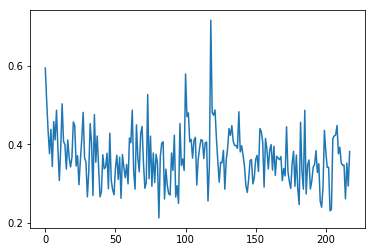

In [183]:
# plotting and diagnose
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    
showPlot(all_losses)

In [ ]:
# validation/test
